In [31]:
# Imports
import cv2
import numpy as np
import pytesseract
import re
import os
from PIL import Image
import matplotlib.pyplot as plt

# Configure Tesseract path (update this based on your installation)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Windows example
# For Mac/Linux, might be: '/usr/local/bin/tesseract' or similar—adjust as needed

print("Setup complete. Ensure Tesseract path is correct for your system.")

Setup complete. Ensure Tesseract path is correct for your system.


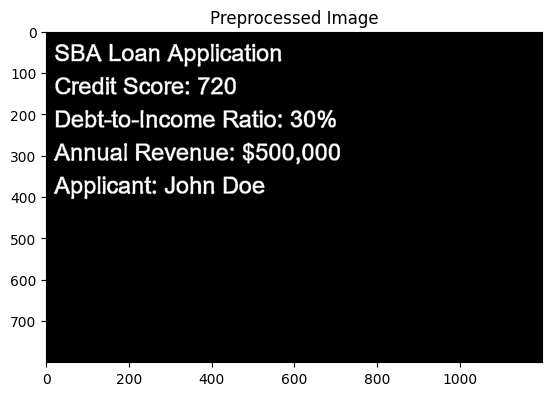

In [32]:
def preprocess_image(image_path):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if image loaded correctly
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    
    # Resize for consistency (optional, adjust DPI as needed)
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    
    # Apply Gaussian blur to reduce noise
    img = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Adaptive thresholding to binarize (black text, white background)
    img = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )
    
    # Dilate to connect text components
    kernel = np.ones((2, 2), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
    
    # Save preprocessed image for debugging
    preprocessed_path = "preprocessed.png"
    cv2.imwrite(preprocessed_path, img)
    
    return preprocessed_path

# Test preprocessing (replace with a sample image path)
sample_image = "sba_loan_doc.png"  # You’ll need a test image
try:
    preprocessed = preprocess_image(sample_image)
    plt.imshow(cv2.imread(preprocessed, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title("Preprocessed Image")
    plt.show()
except ValueError as e:
    print(e)

In [33]:
def extract_text(image_path):
    # Run Tesseract OCR
    text = pytesseract.image_to_string(Image.open(image_path))
    return text

# Test OCR
preprocessed = "preprocessed.png"  # From Cell 2
extracted_text = extract_text(preprocessed)
print("Extracted Text:")
print(extracted_text)

Extracted Text:
SBA Loan Application
Credit Score: 720
Debt-to-Income Ratio: 30%
Annual Revenue: $500,000
Applicant: John Doe



In [34]:
def parse_loan_data(text):
    # Initialize results
    data = {"credit_score": None, "dti_ratio": None, "annual_revenue": None, "applicant": None}
    
    # Regular expressions for key fields
    credit_score_match = re.search(r"Credit Score:?\s*(\d{3})", text, re.IGNORECASE)
    dti_match = re.search(r"Debt-to-Income Ratio:?\s*(\d+\.?\d*)%", text, re.IGNORECASE)
    annual_revenue_match = re.search(r"Annual Revenue:?\s*\$(\d+(?:,\d+)?)", text, re.IGNORECASE)
    applicant_name_match = re.search(r"Applicant:?\s*([A-Za-z\s]+)", text, re.IGNORECASE)
    
    # Extract values
    if credit_score_match:
        data["credit_score"] = int(credit_score_match.group(1))
    if dti_match:
        data["dti_ratio"] = float(dti_match.group(1))
    if annual_revenue_match:
        # Remove commas and convert to float
        revenue_str = annual_revenue_match.group(1).replace(",", "")
        data["annual_revenue"] = float(revenue_str)
    if applicant_name_match:
        data["applicant"] = applicant_name_match.group(1).strip()  # Keep as string, remove extra spaces
    
    return data

# Test parsing
parsed_data = parse_loan_data(extracted_text)
print("Parsed Data:")
print(parsed_data)

Parsed Data:
{'credit_score': 720, 'dti_ratio': 30.0, 'annual_revenue': 500000.0, 'applicant': 'John Doe'}


In [36]:
def process_loan_document(image_path):
    # Step 1: Preprocess
    preprocessed_path = preprocess_image(image_path)
    
    # Step 2: Extract text
    text = extract_text(preprocessed_path)
    print("Extracted Text:")
    print(text)
    
    # Step 3: Parse data
    data = parse_loan_data(text)
    print("Extracted Data:")
    print(data)
    
    return data

# Run full pipeline
sample_image = "sba_loan_doc.png"  # Use your sample file
result = process_loan_document(sample_image)

Extracted Text:
SBA Loan Application
Credit Score: 720
Debt-to-Income Ratio: 30%
Annual Revenue: $500,000
Applicant: John Doe

Extracted Data:
{'credit_score': 720, 'dti_ratio': 30.0, 'annual_revenue': 500000.0, 'applicant': 'John Doe'}
